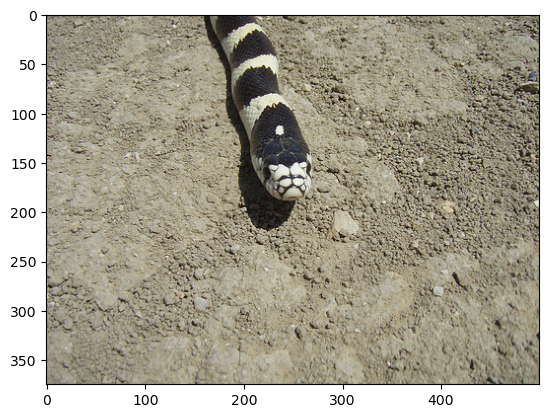

In [2]:
from PIL import Image

image_path = '/local/storage/ding/imagenet2012/n01734418/n01734418_10016.JPEG'
image = Image.open(image_path)
import matplotlib.pyplot as plt
plt.imshow(image)


In [1]:
import torch
from models.KronLeNet import KronLeNet
model = KronLeNet()
# kronlenet.pth save the state_dict of the model
model.load_state_dict(torch.load('kronlenet.pth'))

<All keys matched successfully>

In [2]:
model.kronfc1.a
# find the zeros in kronfc1.a, we consider < 1e-5 as zero
torch.abs(model.kronfc3.a) < 1e-5
# find the position of the zeros
torch.nonzero(torch.abs(model.kronfc3.a) < 1e-5)

tensor([[1, 4, 1],
        [1, 8, 1],
        [3, 4, 0]])

In [3]:
# print(model.kronfc3.a)
N = model.kronfc3.a.shape[0]
for i in range(N):
    print(model.kronfc3.a[i][4][1])
for i in range(N):
    print(model.kronfc3.a[i][8][1])
for i in range(N):
    print(model.kronfc3.a[i][4][0])

tensor(0.0095, grad_fn=<SelectBackward0>)
tensor(-1.3385e-06, grad_fn=<SelectBackward0>)
tensor(0.0017, grad_fn=<SelectBackward0>)
tensor(1.1705e-05, grad_fn=<SelectBackward0>)
tensor(0.1978, grad_fn=<SelectBackward0>)
tensor(3.3394e-07, grad_fn=<SelectBackward0>)
tensor(0.0528, grad_fn=<SelectBackward0>)
tensor(0.0001, grad_fn=<SelectBackward0>)
tensor(-0.0058, grad_fn=<SelectBackward0>)
tensor(2.4071e-05, grad_fn=<SelectBackward0>)
tensor(-0.0004, grad_fn=<SelectBackward0>)
tensor(1.0827e-06, grad_fn=<SelectBackward0>)


In [4]:
# draw a matrix, using the values of kronfc3.a
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(5, 5))
a = model.kronfc3.a.detach().numpy()
N = a.shape[0]
from einops import rearrange
a = rearrange(a, 'n i j -> i j n')
# using norm 2 to squeeze the last dimension
a = np.linalg.norm(a, axis=2)
# show the number of a and add red border in (4,0) (4,1) (8,1) squares
 


<Figure size 1500x1500 with 0 Axes>

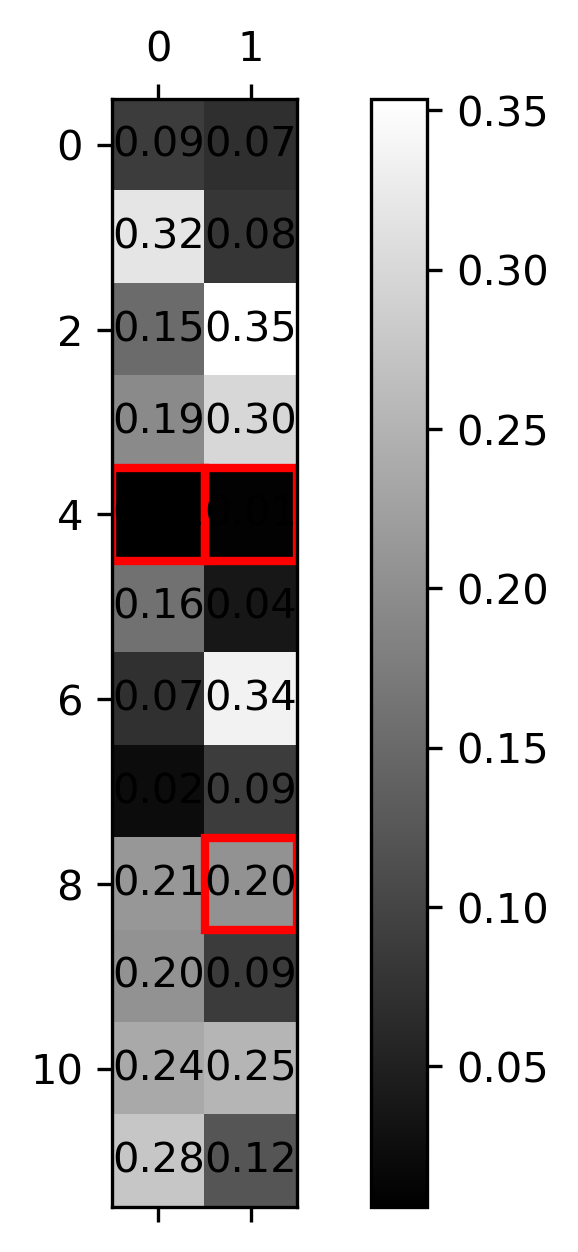

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches



# 创建灰度图
fig, ax = plt.subplots()

# 设置灰度
cax = ax.matshow(a, cmap='gray')

# 在4,0和4,1以及8,1位置画红色边框
rectangles = [
    patches.Rectangle((-0.5, 3.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none'),
    patches.Rectangle((0.5, 3.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none'),
    patches.Rectangle((0.5, 7.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
]

for rect in rectangles:
    ax.add_patch(rect)

# 在中间显示矩阵值
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        ax.text(j, i, f'{a[i, j]:.2f}', va='center', ha='center', color='black')

# 显示颜色条
cbar = fig.colorbar(cax)

plt.show()

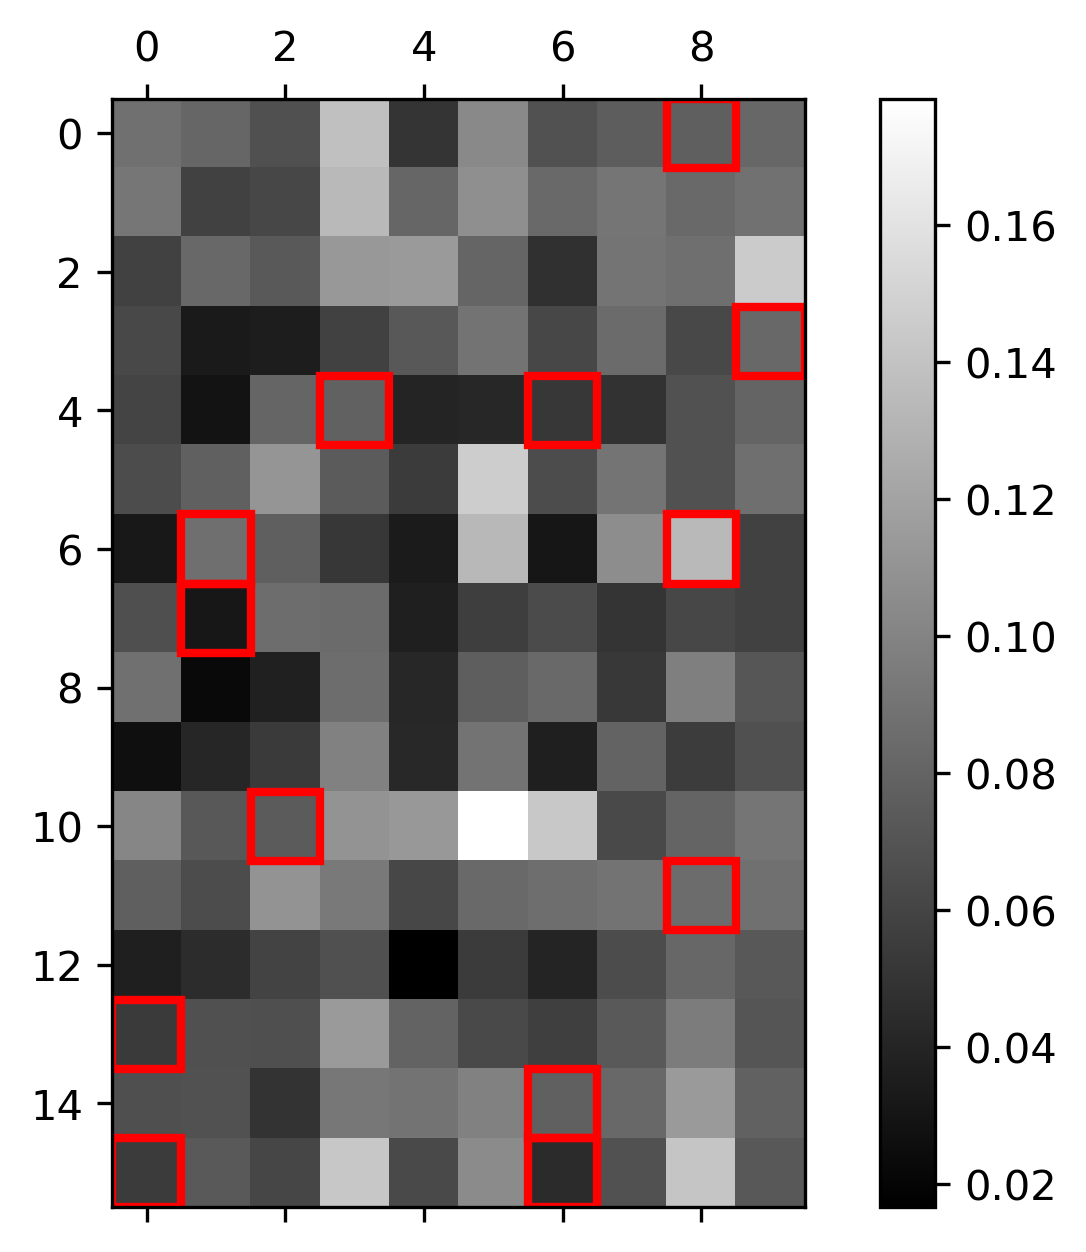

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
index = torch.nonzero(torch.abs(model.kronfc1.a) < 1e-5)
a = model.kronfc1.a.detach().numpy()

N = a.shape[0]
from einops import rearrange
a = rearrange(a, 'n i j -> i j n')
# using norm 2 to squeeze the last dimension
a = np.linalg.norm(a, axis=2)

# 创建灰度图
fig, ax = plt.subplots()

# 设置灰度
cax = ax.matshow(a, cmap='gray')

# 在4,0和4,1以及8,1位置画红色边框

rectangles = [
    # patches.Rectangle((-0.5, 3.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none'),
    # patches.Rectangle((0.5, 3.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none'),
    # patches.Rectangle((0.5, 7.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
]
for i in index:
    rectangles.append(patches.Rectangle((i[2]-0.5, i[1]-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none') )

for rect in rectangles:
    ax.add_patch(rect)

# 在中间显示矩阵值
# for i in range(a.shape[0]):
#     for j in range(a.shape[1]):
#         ax.text(j, i, f'{a[i, j]:.2f}', va='center', ha='center', color='black')

# 显示颜色条
cbar = fig.colorbar(cax)

plt.show()

In [9]:
a.max(),a.min()

(0.17847148, 0.016580207)

In [1]:
from global_utils.torch_utils.cuda import find_gpus
find_gpus(1)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from einops import rearrange, reduce, repeat
import torchvision
from torchvision import datasets, transforms

from gkpd.tensorops import kron
from time import time 

from global_utils.tools import random_seed
from global_utils.torch_utils.Args import TorchArgs

random_seed(2024)


group_id = 0





transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)




class KronLinear(nn.Module):
    def __init__(self, rank, a_shape, b_shape, structured_sparse=False, bias=True) -> None:
        """Kronecker Linear Layer

        Args:
            rank (int): _description_
            a_shape (_type_): _description_
            b_shape (_type_): _description_
            structured_sparse (bool, optional): _description_. Defaults to False.
            bias (bool, optional): _description_. Defaults to True.
        """
        super().__init__()
        self.rank = rank
        self.structured_sparse = structured_sparse
        if structured_sparse:
            self.s = nn.Parameter(torch.randn( *a_shape), requires_grad=True)
        self.a = nn.Parameter(torch.randn(rank, *a_shape), requires_grad=True)
        self.b = nn.Parameter(torch.randn(rank, *b_shape), requires_grad=True)
        nn.init.xavier_uniform_(self.a)
        nn.init.xavier_uniform_(self.b)
        self.a_shape = self.a.shape
        self.b_shape = self.b.shape
        bias_shape = np.multiply(a_shape, b_shape)
        if bias:
            self.bias = nn.Parameter(torch.randn(*bias_shape[1:]), requires_grad=True)
        else:
            self.bias = None
        
    def forward(self, x):
        # a = self.a
        # if self.structured_sparse:
        #     a = self.s.unsqueeze(0) * self.a
        
        # # a = self.s.unsqueeze(0) * self.a
        # w = kron(a, self.b)
        
        # out = x @ w 
        # if self.bias is not None:
        #     out += self.bias.unsqueeze(0)
        # return out
        # =========================
        a = self.a
        if self.structured_sparse:
            a = self.s.unsqueeze(0) * self.a
        
        # a = self.s.unsqueeze(0) * self.a
        # w = kron(a, self.b)
        x_shape = x.shape 
        b = self.b
        r = self.a_shape[0]
        x = torch.reshape(x, (-1, x_shape[-1]))
        # print(x.shape, self.a_shape, self.b_shape)
        b = rearrange(b, 'r b1 b2 -> b1 (b2 r)')
        # print(b.shape)
        x = rearrange(x, 'n (a1 b1) -> n a1 b1', a1=self.a_shape[1], b1=self.b_shape[1])
        out = x @ b
        out = rearrange(out, 'n a1 (b2 r) -> r (n b2) a1', b2=self.b_shape[2], r=r)
        out = torch.bmm(out, a)
        out = torch.sum(out, dim=0).squeeze(0)
        out = rearrange(out, '(n b2) a2 -> n (a2 b2)', b2=self.b_shape[2])
        out = torch.reshape(out, x_shape[:-1] + (self.b_shape[2] * self.a_shape[2],))
        
        
        
        if self.bias is not None:
            out += self.bias.unsqueeze(0)
        return out
    
class KronLeNet(nn.Module):
    def __init__(self, group_id=1) -> None:
        super(KronLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        rank1 = 21
        rank2 = 10
        rank3 = 4
        Kronnecker_group = [[
    [(16, 10), (16, 12)],
    [(10, 12), (12, 7)],
    [(12, 2), (7, 5)]
    ],
    [[(8, 10), (32, 12)],
     [(5, 6), (24, 14)],
     [(4, 2), (21, 5)]
     ],
    [[(32, 12), (8, 10)],
     [(24, 14), (5, 6)],
        [(21, 5), (4, 2)]
     ],
    [[(4, 5), (64, 24)],
     [(5, 3), (24, 28)],
     [(4, 2), (21, 5)]
     ],
    ]
        
        self.kronfc1 = KronLinear(rank1, Kronnecker_group[group_id][0][0], Kronnecker_group[group_id][0][1], bias=False, structured_sparse=True)
        
        self.kronfc2 = KronLinear(rank2, Kronnecker_group[group_id][1][0], Kronnecker_group[group_id][1][1], bias=False, structured_sparse=True)
        
        self.kronfc3 = KronLinear(rank3, Kronnecker_group[group_id][2][0], Kronnecker_group[group_id][2][1], bias=False, structured_sparse=True)
        self.relu3 = nn.LeakyReLU()
        self.relu4 = nn.LeakyReLU()


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = self.relu3(self.kronfc1(x))
        x = self.relu4(self.kronfc2(x))
        x = self.kronfc3(x)
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KronLeNet(group_id=group_id).to(device)

# calcu params of model
def calcu_params(model):
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
    return total_params
print(f"total params: {calcu_params(model)}")


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def calculate_sparsity(model, threshold=1e-6):
    total_params = 0
    sparse_params = 0

    for param in model.parameters():
        total_params += param.numel()  # 统计参数总数
        sparse_params += torch.sum(torch.abs(param) < threshold).item()  # 统计绝对值小于阈值的参数数量

    sparsity = sparse_params / total_params  # 计算稀疏性
    return sparsity, sparse_params, total_params


def test(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print(f"Accuracy: {100 * correct/total}")
    return 100 * correct/total
    
accuracy = test(model, test_loader)






using GPU idx: # 2
total params: 12544
Accuracy: 9.619999885559082


In [4]:
model.load_state_dict(torch.load('./model_save/mnist_kron_sparse_2.pth'))

<All keys matched successfully>

In [8]:
model.kronfc1.s.shape

torch.Size([32, 12])

In [2]:
from models.LeNet import LeNet
lenet = LeNet()

def kronlenet2lenet(kronlenet, lenet):
    lenet.conv1.weight.data = kronlenet.conv1.weight.data
    lenet.conv1.bias.data = kronlenet.conv1.bias.data
    lenet.conv2.weight.data = kronlenet.conv2.weight.data
    lenet.conv2.bias.data = kronlenet.conv2.bias.data
    a1 = kronlenet.kronfc1.a * kronlenet.kronfc1.s.unsqueeze(0)
    a2 = kronlenet.kronfc2.a * kronlenet.kronfc2.s.unsqueeze(0)
    a3 = kronlenet.kronfc3.a * kronlenet.kronfc3.s.unsqueeze(0)
    b1 = kronlenet.kronfc1.b
    b2 = kronlenet.kronfc2.b
    b3 = kronlenet.kronfc3.b
    lenet.fc1.weight.data = kron(a1, b1)
    print(lenet.fc1.weight.data.shape)
    lenet.fc2.weight.data = kron(a2, b2)
    lenet.fc3.weight.data = kron(a3, b3)
    if kronlenet.kronfc1.bias is not None:
        lenet.fc1.bias.data = kronlenet.kronfc1.bias.data
    if kronlenet.kronfc2.bias is not None:
        lenet.fc2.bias.data = kronlenet.kronfc2.bias.data
    if kronlenet.kronfc3.bias is not None:        
        lenet.fc3.bias.data = kronlenet.kronfc3.bias.data
    return lenet 
lenet_test_init = time()
lenet = lenet.to(device)
accuracy = test(lenet, test_loader)
print("inference time:", time()-lenet_test_init)


Accuracy: 5.099999904632568
inference time: 1.2561702728271484


forward flops:  563280


STAGE:2024-02-06 04:49:35 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:49:35 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:49:35 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [30]:
def forward_backward_flops(model, inputs, label):
    from torch.profiler import profile
    inputs = torch.randn(1, 1, 28, 28)
    inputs = inputs.to(device)
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        with_flops=True) as prof:
            outputs = lenet(inputs)
    events = prof.events()
    forward_flops = sum([int(evt.flops) for evt in events]) 
    print("forward flops: ", forward_flops)
    # forward flops:  3627132948
    label = torch.tensor([1]).cuda()
    ### forward + backward
    optimizer = optim.SGD(lenet.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    # warm up cuda memory allocator
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    outputs = model(inputs)
    with torch.profiler.profile(
        activities=[
            torch.profiler.ProfilerActivity.CPU,
            torch.profiler.ProfilerActivity.CUDA,
        ],
        with_flops=True) as prof:
            outputs = model(inputs) 
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
                
    events = prof.events()
    fwbw_flops = sum([int(evt.flops) for evt in events]) 
    print("forward + backward flops: ", fwbw_flops)
    # forward + backward flops:  3628081684
    print("forward + backward - forward:", fwbw_flops - forward_flops)
    # forward + backward - forward: 948736

In [3]:
import torch
from thop import profile




# 随机生成一个输入样本，可以根据你的模型输入要求来调整
inputs = torch.randn(1, 1, 28, 28)
inputs = inputs.to(device)
# 使用thop的profile函数来计算FLOPs
flops, params = profile(lenet, inputs=(inputs,))
label = torch.tensor([1])
optimizer = optim.Adam(lenet.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
print(f"FLOPs: {flops / 1e3} K")
print(f"Parameters: {params / 1e6} M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 281.64 K
Parameters: 0.044426 M


In [37]:
lenet = lenet.to(device)
print(forward_backward_flops(lenet, inputs, label))

forward flops:  563280
forward + backward flops:  729840
forward + backward - forward: 166560
None


STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 05:03:44 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [23]:
from deepspeed.profiling.flops_profiler import get_model_profile
from deepspeed.accelerator import get_accelerator
with get_accelerator().device():
    profile = get_model_profile(lenet, input_shape=(1,1,28,28), )


[2024-02-06 04:46:16,592] [INFO] [profiler.py:1205:get_model_profile] Flops profiler warming-up...
[2024-02-06 04:46:16,594] [INFO] [profiler.py:80:start_profile] Flops profiler started

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per GPU:                                                         44.43 K 
params of model = params per GPU * mp_size:                             0       
fwd MACs per GPU:                                                       281.64 KMACs
fwd flops per GPU:                                  

NameError: name 'y' is not defined

In [21]:
from deepspeed.profiling.flops_profiler import FlopsProfiler
prof = FlopsProfiler(lenet)
profile_step = 5
print_profile= True

for step, batch in enumerate(train_loader):
  # start profiling at training step "profile_step"
  if step == profile_step:
    prof.start_profile()

  # forward() method
  loss = criterion(lenet(batch[0].to(device)), batch[1].to(device))

  # end profiling and print output
  if step == profile_step: # if using multi nodes, check global_rank == 0 as well
    prof.stop_profile()
    flops = prof.get_total_flops()
    macs = prof.get_total_macs()
    params = prof.get_total_params()
    if print_profile:
        prof.print_model_profile(profile_step=profile_step)
    prof.end_profile()

  # runs backpropagation
  loss.backward()

  # weight update
  optimizer.step()

[2024-02-06 04:23:36,436] [INFO] [profiler.py:80:start_profile] Flops profiler started

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 5:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per GPU:                                                         44.43 K 
params of model = params per GPU * mp_size:                             0       
fwd MACs per GPU:                                                       72.1 MMACs
fwd flops per GPU:                                                      147.7 M 
fwd flops of model = fwd flops per GPU * mp_size:                       

In [32]:
model0 = KronLeNet(group_id=0).to(device)
print(model0)
model0.kronfc1.a.data = torch.zeros_like(model.kronfc1.a.data)
with get_accelerator().device():
    profile = get_model_profile(model0, input_shape=(1,1,28,28))
print(forward_backward_flops(model0, inputs, label))

KronLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (kronfc1): KronLinear()
  (kronfc2): KronLinear()
  (kronfc3): KronLinear()
  (relu3): LeakyReLU(negative_slope=0.01)
  (relu4): LeakyReLU(negative_slope=0.01)
)
[2024-02-06 04:56:15,837] [INFO] [profiler.py:1205:get_model_profile] Flops profiler warming-up...
[2024-02-06 04:56:15,839] [INFO] [profiler.py:80:start_profile] Flops profiler started

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number 

STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:56:15 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


forward + backward flops:  1232368
forward + backward - forward: 669088
None


In [33]:
model1 = KronLeNet(group_id=1).to(device)
with get_accelerator().device():
    profile = get_model_profile(model1, input_shape=(1,1,28,28))

print(forward_backward_flops(model1, inputs, label))

[2024-02-06 04:57:03,661] [INFO] [profiler.py:1205:get_model_profile] Flops profiler warming-up...
[2024-02-06 04:57:03,663] [INFO] [profiler.py:80:start_profile] Flops profiler started

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per GPU:                                                         16.55 K 
params of model = params per GPU * mp_size:                             0       
fwd MACs per GPU:                                                       264.52 KMACs
fwd flops per GPU:                                  

STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:57:03 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [34]:
model2 = KronLeNet(group_id=2).to(device)
with get_accelerator().device():
    profile = get_model_profile(model2, input_shape=(1,1,28,28))

print(forward_backward_flops(model2, inputs, label))

[2024-02-06 04:58:34,358] [INFO] [profiler.py:1205:get_model_profile] Flops profiler warming-up...
[2024-02-06 04:58:34,360] [INFO] [profiler.py:80:start_profile] Flops profiler started

-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per GPU:                                                         17.25 K 
params of model = params per GPU * mp_size:                             0       
fwd MACs per GPU:                                                       341.64 KMACs
fwd flops per GPU:                                  

STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-06 04:58:34 392144:392144 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [12]:

flops, params = profile(lenet, inputs=(inputs,))

print(f"FLOPs: {flops / 1e3} K")
print(f"Parameters: {params / 1e6} M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 281.64 K
Parameters: 0.044426 M
